In [3]:
import numpy as np
import matplotlib.pyplot as plt

% LaTeX macros...
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\P}{\mathcal{P}}$
$\newcommand{\U}{\mathcal{U}}$
$\newcommand{\J}{\mathfrak{J}}$
$\newcommand{\x}{\mathbf{x}}$
$\renewcommand{\v}{\mathbf{v}}$
$\renewcommand{\u}{\mathbf{u}}$
$\newcommand{\bigO}{\mathcal{O}}$
$\newcommand{\dd}{\, \mathrm{d}}$
$\newcommand{\dt}[1]{\dot{#1}}$
$\newcommand{\d}{\mathrm{d}}$
$\newcommand{\T}{\mathrm{T}}$
$\newcommand{\intset}[2]{\{#1, ..., #2\}}$

## Utilitary functions

In [4]:
def plot_trajectory(predicted_x=None, gt_x=None, crop_y=False):
    """
    Plots the ground truth trajectory vs the predicted trajectory on a (t, x) plot.
    
    Parameters
    ----------
    predicted_x: None | np.array of floats
        Regularly spaced samples of the predicted trajectory. If None, this trajectory is not plotted.
    gt_x: None | np.array of floats
        Regularly spaced samples of the ground truth trajectory. If None, this trajectory is not plotted.
    crop_u: bool
        If True, crop the y axis to zoom on [-1, 0]
        
    Return
    ------
    None
    """
    plt.figure()
    if predicted_x is not None:
        t_prediction = np.linspace(0, T, predicted_x.shape[0])
        plt.plot(t_prediction, predicted_x, label="Prediction", color="tab:blue")
    if gt_x is not None:
        t_gt = np.linspace(0, T, gt_x.shape[0])
        plt.plot(t_gt, gt_x, label="Ground truth", color="tab:orange")
    if crop_y:
        plt.ylim([-1, 0])
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Trajectories")
    plt.legend()
    plt.grid()
    plt.show()


def plot_control(predicted_u=None, gt_u=None):
    """
    Plots the ground truth control vs the predicted control on a (t, u) plot.
    
    Parameters
    ----------
    predicted_u: None | np.array of floats
        Regularly spaced samples of the predicted control. If None, this control is not plotted.
    gt_u: None | np.array of floats
        Regularly spaced samples of the ground truth control. If None, this control is not plotted.
        
    Return
    ------
    None
    """
    plt.figure()
    if predicted_u is not None:
        t_prediction = np.linspace(0, T, predicted_u.shape[0])
        plt.scatter(t_prediction, predicted_u, label="Prediction", color="tab:blue", marker="x")
    if gt_u is not None:
        t_gt = np.linspace(0, T, gt_u.shape[0])
        plt.plot(t_gt, gt_u, label="Ground truth", color="tab:orange")
    plt.xlabel("t")
    plt.ylabel("u")
    plt.title("Controls")
    plt.legend()
    plt.grid()
    plt.show()

Notations:
- $\dt{x}$ is the derivative in time of $x$;
- if $x$ is a column vector, $x^\T$ is the corresponding row vector;
- $A^\T$ is the transpose of $A$. 

# Introduction

In this notebook, we discuss some motivations for the use of RL (Reinforcement Learning) for different kinds of applications, and we illustrate some of the strengths of RL, but also some of its drawbacks. We also start a discussion on TL (Transfer Learning) for RL as a way to alleviate one of the main drawbacks of RL, which is its data-inefficacy leading to resource-intensive traning phases.

## Reinforcement learning: strengths and weaknesses

RL is a machine learning framing in which an agent evolves in an environment by making decisions and tries to maximize a sum of rewards that are collected as it evolves through the environment. More precisely, a problem formulated in the RL framing is a sequential problem where at each step, the environment is in a given state. The agent receives a (full or partial) observation of this state and takes a decision accordingly. Resulting from that decision, the environment grants a reward to the agent and moves to a new state: this is the starting point for a new step of the problem. Therefore, the goal of the agent is to take decisions so as to maximize its cumulative rewards, not only the current ones but also future ones (whch might be a long time in the future).

RL problems are hence particularly suited to iterative problems of adaptive control of a system in which the environment evolves, sometimes unpredictibly, spontaneously or in response to the adopted control.

Before mentioning applications for which RL is well suited, let's recall some strengths and weaknesses of RL.
On the one hand:

- As for many machine learning methods (especially deep learning approaches), once trained, an RL agent can solve the problems it has been trained for with very little computational cost (which makes it ideal for online problems).

- It can work model-free, meaning that it doesn't need to know the model underlying the transition of the environment from one state to another in response to a decision. Instead, it can solely rely on a set of samples, where a sample has to be udnerstood as a transition, that is a tuple (state, action, reward, new state).

- It can learn online, meaning that it can keep increasing its performance as it evolves in a environment, which can be useful in cases where the environment changes over time.

- Thanks to its ability to estimate the quality of a given state, it can efficiently tackle problems with long-term rewards.

- Likewise, but also thanks to the compromise it proposes to find between exploration of the environment and exploitation of well-rewarding paths, it can tackle high-dimensional problems.

- Because it works in a _divide-and-conquer_ fashion, it is a good starting point to simplify a problem by simplifying each of its sub-problems.

On the other hand:

- It needs the design of a reward function that can be hard to define: you want this quantitative reward to be representative of a goal that is sometimes qualitative; you don't want to make it too long-term, but artificially defining intermediary rewards might add biases in the training...

- It is usually sample-inefficient, meaning that it needs a lot of data to learn. Depending on your problem, that might not be too troublesome if data can be easily generated by simply interacting with the environment or even by simulation.

- Adapting RL methods to continuous-time problems is not always straightforward, and sometimes you'll want to discretize your problem, leading to approximations.

- More generally, adapting a problem to RL needs cumbersome and heavy-weight modelling.

- So far, the RL research landscape is not well unified. For example, unlike _e.g._ supervised learning which comes with well established libraries (_Pytorch_, Tensorflow, scikit-learn...), RL doesn't have a unified library with well-implemented methods but also elementary blocks to customize your own methods.

## What to use reinforcement learning for?

Firstly, here are some situations where you _don't_ want to use reinforcement learning:

- There is a single instance of your problem that you want to solve offline (and classical methods can give you satisfying results).

- Real time problems but that are simple and for which classical methods work well and fast.

- Problems where you don't have much data and you want good results right away.

Instead, msot scenarios for which RL can be applied involve solving an online problem in an adaptive way, that is real-time problems where you discover the state of the environment at the last moment and you have to take decisions efficiently. These problems can be of various type: reaching a target in limited time, stabilizing the system in this target, finding maximizing a function over a trajectory, or anything for which a reward can be designed correctly. In some cases, the model might be known, but you still cannot design a planned control for the system for various reasons:

- It is stochastic. In this case, you could design an offline-control that optimizes the _expected_ reward, but you would not benefit from information discovered as you go. A variation of this case is when you the initial condition is random and you want, for example, to reach a final target.

- The system is deterministic but _chaotic_ (think of an inverted double-pendulum that we want ), matking a pre-defined control unreliable.

- Equivalently, the system is _uncertain_ (for example, you don't know some parameter with full precision, or you are not sure how your system will behave exactly in some circumstances).

- The model _varies with time_.

- The problem is offline, but it is so complex (_e.g._ high-dimensional) that you want to address it in an online framing to explore solutions in an efficient manner. This is what happens when using RL to beat some video games.

In these contexts, you might still be able to use some classical adaptive control methods with feedback to adjust the control as you go (potentially using some approximations of the model). Therefore, in these cases, Rl should only be considered if traditional adaptive methods are not performing fast enough or well enough; in particular in cases that seem to match the strengths of RL mentioned above such as long-term rewards. But there are also cases of online problems where you don't even have any model at all, again for various possible reasons:

- The real-world black-box system you are studying is too complex to be modelled with traditional inverse problem solving.

- Solving an inverse problem is possible, but would consume too much resources. This scenario should be considered with caution, as gathering enough data and training an RL agent long enough to get satsifying results might be even more resource-consuming!

- You don't have enough data to infer a model by inverse problem solving, and an efficient way to gather data is by interacting with the system: RL might be a good choice to gather this data in a clever way.

- You don't _want_ to use a model because model-based methods have proved unefficient, for example because of the bias they introduce (see for example [@sivak_quantum]).

In these cases, you can hardly use any classical model-based method, and RL is one option to have some solution.

Now, imagine problems where the environment is combining many of these difficulties: complex black-box systems with unpredictible events and time-varying mechanics at the same time. This makes very complex problems to tackle with traditional methods. This is for example the case in autonomous driving, where deep RL is used for motion planning and control [@bachute_autonomous_driving]. Indeed, in this example, the car is a complex system, the shape of the road and the behaviour of the car in front of the controlled one can't be predicted and the response of the car to inpyts might change depending on the state of the road, but also of the car components...

A last class of applications that we could mention is that of inverse reinforcement problems, which is of different nature and aim: we have a control (or a behaviour) that optimizes some objective, and we want to find a reward that is being optimized by this control. This could have several applications:

- You want to study and explain the agent that applied the control. For example, to explain the speed of human motions [@berret_human_motion] .

- You have some expert demonstration to solve a problem, and you want to design a reward that can then be used to train _e.g._ an RL agent more efficiently.

From there, there are plenty of applications of RL in many domains, from robotics, to finance, to operation research, to medical imaging, to quantum mechanics. Many of these applications can be found in the litterature, and we are not reviewing it here.

However, in the future, we will be interested in problems involving physical ODEs and PDEs, especially in fluid mechanics. Paul Garnier made a good review on recent research on RL applied to systems involving fluid mechanics [@garnier_fluid_mechanics]. One of them include a control problem involving two fishes, one leader and one follower, and the objective is to learn the appropriate swimming motion of the follower so as to benefit from the fluid turbulence caused by the leader, so as to minimize the energy necessary to swim [@novati_synchronisation_swimmers]. These problems usually involve models that are known (after all, the system is ruled by the Navier-Stokes equaton, or some approximation of it), but which are quite chaotic, sometimes stochastic (for example the previous problem, the motion of the leader might not be known entirely) and also very computationally demanding. Even with a perfectly known model, classical optimization methods are immensly resource-consuming.

This is why RL may be of some help in these problems.

## Goal of this notebook

The aim of this notebook is essentially two-fold:

1. Motivate the use of RL in problems involving physical ODEs by illustrating it with a very simple, linear control problem. The idea being to highlight the benefits of RL in this example in terms of computational gains, in circumstances where you don't know the initial conditions in advance and the model contains a share of stochasticity. But we will also underline some drawbacks of RL already mentioned above. Besides, this example will inevitably be somewhat artificial, because we already have an analytical solution and the problem is very simple (making RL an unnecessarily complex solution in this case). 

2. Exemplify the use of TL in RL to see how it can compensate for one of RL's main drawbacks, which is that of its sample inefficacy. This is particuarly relevant for fluid mechanics where samples can be expansive to get due to the costly forward simulations.

---

# Outline

1. Introduction of the toy-problem

2. Analytical solution

2. Short review of traditional methods

2. Disctretization of the physical problem in time

3. Solving by gradient descent

4. Introduction of an RL method to tackle the problem

5. Solving by Reinforcement learning

6. Analysis of the results

    1. General performance

    2. Interpretation of the algorithm's learning

    3. Computational gain

    4. Drawbacks

7. Transfer Learning

    1. Introduction of the method

    2. Application of the method

    3. Analysis of the results

---

# Introduction of the toy problem

Let's consider a small but typical problem. We have a system, for example a cart, that can move along a 1D axis $x$. We want to bring this cart from an initial position $x_0$ to a target position, namely $x = 0$, in finite time $T$ by exerting a force that we which to minimize.

More precisly, the cart is assimilated to a mechanical point of mass $m > 0$ and its position is denoted by $x \in \Omega = \R$. The initial position is drawn uniformly randomly in $\Omega_0 = [-1, 0]$ and the initial velocity is null. The force we apply on the cart at a given instant is denoted by $u \in U = \R$, and we are looking for a control that maps any time $t \in [0, T]$ to an action in $U$; this control is denoted by $\mu \in \U = L^1\big( [0, T], U \big)$. The dynamics of the system write:
$$
    \begin{cases}
        m \ddot{x}(t) = \mu(t) & \forall t \in [0, T],\\
        x(0) = x_0,\\
        \dt{x}(0) = 0,
    \end{cases}
$$
and we want to find $\mu$ that optimizes the cost functional $J$:
$$
    \min_{\mu \in \U} J(\mu)
$$
where
$$
    J(\mu) = \lambda_P x(T)^2 + \lambda_V \dt{x}(T)^2 + \int_0^T \mu(t)^2 \dd t
$$
with $\lambda_P,\, \lambda_V > 0$ two parameters that sets the penalizations for not reaching the target a time $T$ and not stopping at $T$ respectively. One interpretation could be that we have some tolerance on the final position, we can stop instantaneously at time $T$ but this damages the cart's brakes, and finally exerting a force has some energy cost. Thereafter, we'll also denote $\lambda = (\lambda_P, \lambda_V)$ to alleviate notations.

Note that this problem is already formulated as a continuous optimal control problem with a mostly known model. In what follows, we will consider $m$ as an uknown parameter of the problem, while $\lambda$ is known; but for the sake of simulation we need to choose these parameters right away.

In [28]:
m = 1  # Mass of the cart
LAMBDA_P = 100  # Penalization for not reaching the target at time T
LAMBDA_V = 50  # Penalization for not reaching the target at time T
T = 1  # Time horizon of the problem

Before going further, let's characterize this problem a bit. It is deterministic, of fixed time-horizon, continuous in time and with fully-observed state. The fact that we add some penalization on the final state makes it a problem with a "long-time" return, in the sense that most of the cost comes at the very end of the evolution process; but at the same time, penalization on the intensity of the force introduces intermediary costs along a trajectory. We could also have chosen hard constraints, for example on attaining the target at the final time, but ultimately we'll need to characterize this constraint in some way when implementing an RL method.

# Solve analytically

For the sake of evaluating our results, we will work out an analytical solution for this problem. In practice, you wouldn't have such a solution (otherwise, you wouldn't bother doing any of this...).

The above problem can be seen as a linear quadratic regulator as follows:
$$
\begin{cases}
    \dot{X}(t) = A X(t) + B \mu(t) & \forall t \in [0, T],\\
    X(0) = (0, 0)^\T,
\end{cases}
$$
with
$$
    \forall t \in [0, T], \ X(t) = \begin{pmatrix}
        x(t)\\
        \dot{x}(t)
    \end{pmatrix}, \qquad
    A = \begin{pmatrix}
        0 & 1\\
        0 & 0
    \end{pmatrix} \quad and \quad
    B = \frac{1}{m} \begin{pmatrix}
        0\\
        1
    \end{pmatrix}
$$
and
$$
    J(\mu) = \int_0^T (\mu(t)^\T R\mu(t)) \dd t + X(T)^\T D X(T)
$$
with
$$
    R = 1 \quad and \quad D = \begin{pmatrix}
        \lambda_P & 0\\
        0 & \lambda_V
    \end{pmatrix}
$$

<!-- Using the adjoint state $p$ to solve this problem, we get:
$$
\boxed{
\forall t \in [0, T], \ 
\begin{cases}
    \mu(t) = \frac{1}{m} \big( \lambda_P x(T) t - C \big),\\[1ex]
     p(t) = \begin{pmatrix}
        \lambda_P x(T)\\
        -\lambda_P x(T) t + C
    \end{pmatrix},\\[1em]
    x(t) = \frac{\lambda_P x(T)}{6 m^2} t^3 - \frac{C}{2 m^2} t^2 + x_0,
\end{cases}
}
$$
with
$$
C = \lambda_V \dot{x}(T) + \lambda_P x(T) T, \qquad x(T) = x_0 \frac{D_1}{D_1 C_2 - C_1 D_2} \quad \text{and} \quad \dot{x}(T) = x_0 \frac{D_2}{C_1 D_2 - C_2 D_1}
$$
where
$$
    C_1 = \frac{6 m^2 + 2 \lambda_P T^3}{6 m^2}, \quad C_2 = \frac{\lambda_V T^2}{2 m^2} \quad \text{and} \quad D_1 = \frac{\lambda_P T^2}{2 m^2}, \quad D_2 = \frac{\lambda_V T}{m^2}
$$ -->

Using the adjoint state $p$ to solve this problem, we get:
$$
\boxed{
\forall t \in [0, T], \ 
\begin{cases}
    \mu(t) = \frac{12 m \lambda_P x_0}{\lambda_P T^3 + 12 m^2} t - \frac{6 m \lambda_P T x_0}{\lambda_P T^3 + 12 m^2} ,\\[1ex]
    x(t) = \frac{2 \lambda_P x_0}{\lambda_P T^3 + 12 m^2} t^3 - \frac{3 \lambda_P T x_0}{\lambda_P T^3 + 12 m^2} t^2 + x_0,\\[1ex]
    \dot{x} = \frac{6 \lambda_P x_0}{\lambda_P T^3 + 12 m^2} t^2 - \frac{6 \lambda_P T x_0}{\lambda_P T^3 + 12 m^2} t
\end{cases}
}

In [29]:
def ground_truth(x_0, t):
    """
    Analytical expressions of the trajectory and the control for the continuous control problem.
    
    Parameters
    ----------
    x_0: float in [-1, 0]
        Initial condition.
        
    Return
    ------
    A tuple of np.arrays (gt_x, gt_x_dot gt_u), all of shape (res).
    """
    D = LAMBDA_P*T**3 + 12*m**2
    return (
        (2*LAMBDA_P*x_0/D)*t**3 - (3*LAMBDA_P*T*x_0/D)*t**2 + x_0,
        (6*LAMBDA_P*x_0/D)*t**2 - (6*LAMBDA_P*T*x_0/D)*t,
        (12*m*LAMBDA_P*x_0/D)*t - (6*m*LAMBDA_P*T*x_0/D)
    )

In [30]:
def ground_truth_sample(x_0, res=10000):
    """
    Sample of the trajectory and control solution to the continuous control problem.
    
    Parameters
    ----------
    x_0: float in [-1, 0]
        Initial condition.
    res: int
        Number of points to sample.
        
    Return
    ------
    A tuple of np.arrays (gt_x, gt_u) both of shape (res).
    """
    t = np.linspace(0, T, res)
    return ground_truth(x_0, t)

In [31]:
def cost(x, x_dot, u):
    """
    Compute an approximation of the cost function evaluated in a given trajectory-control pair (x, u), using trapezoidal rule.
    
    Parameters
    ----------
    x: np.array of floats
        The trajectory.
    x_dot: np.array of floats
        The temporal derivative of the trajectory.
    u: np.array of floats
        The control.
            
    Return
    ------
    Approximation of the cost.
    """
    return LAMBDA_P*x[-1]**2 + LAMBDA_V*x_dot[-1]**2 + np.trapz(u**2, dx=T/u.shape[0])

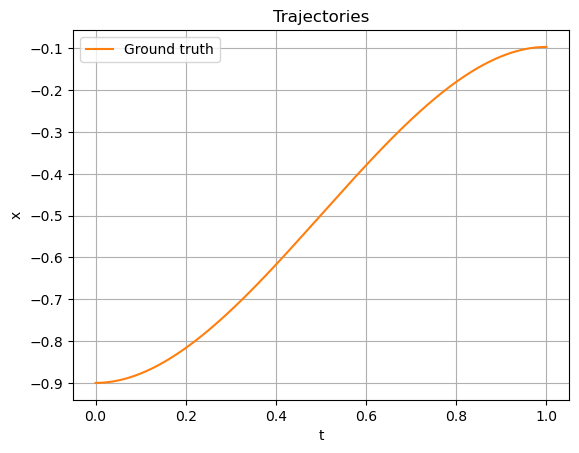

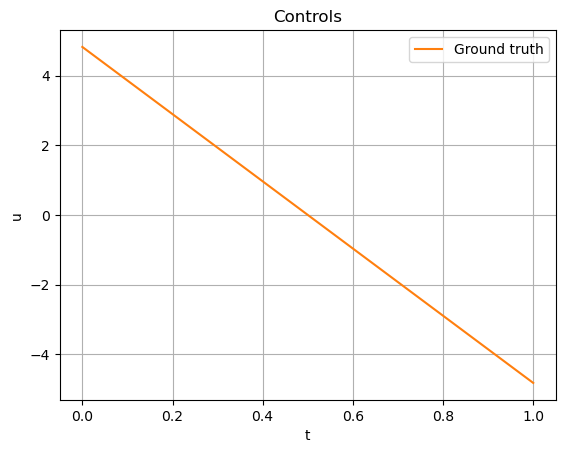

8.677796711112443

In [35]:
gt_x, gt_x_dot, gt_u = ground_truth_sample(x_0=-0.9)
plot_trajectory(gt_x=gt_x)
plot_control(gt_u=gt_u)
# Approximation of the optimal cost
cost(gt_x, gt_x_dot, gt_u)

# Short review of traditional methods

Let's now assume that we don't have an analytical solution. How can we solve this control problem? The classical, naive way would be to solve an inverse problem to fit a model and determine $m$ thereby. From there, we can use one of the traditional methods described below.

Classical methods that don't resort to ML to solve control problems can be classified into 3 classes of methods:

1. Dynamic programming methods, for example integrating HJB equations backwards to get the value function and derive a control. These are very computationally expansive methods that are rarely used as-is (approximations are used, which is somewhat what we are doing with RL...).

2. Direct methods, in which the state equation is discretized in time and the state and/or the control are parameterized, so as to end up with a (usually high-dimensional but sparse) NLP problem that is solved with traditional solvers. These solvers might use computations of the gradient, that may be worked out using integrations of the adjoint state equation.

3. Indirect methods use the theory of calculus of variations and Pontryagin's minimum principle to derive a non-linear system to solve. These methods usually reduce to solving an problem of the type $F(x, p, u) = 0$.

Direct and indirect methods typically come in traditional variants:

1. Single/multiple shooting methods: these are suited to boundary value problems with multiple boundaries. In essence: one boundary is fixed, one control is proposed and the solution corresponding solution is integrated starting from this boundary up to the other boundarie(s) to see if constraints at these boundaries are fulfilled. If they are not, another control is propsoed to try and get closer to the boundary constraints, and so on. In the multiple shooting variant, starting from the initial boundary, the proposed solution is only integrated up to a certain point from which another portion of the control is proposed an so on until the other boundaries. This allows to alleviate the difficulties of long-term integrations in which numerical errors might accumulate and grow, especially if the state equation is very sensitive.

2. Local/global collocation methods: the collocation method initially refers to a method used to solve forward problems in which the state function $x$ is approximated by a parameterized function (for example as a polynomial function) and the coefficients for this approximating function are chosen so that $x$ verifies the state equation at given points (called collocation points). This moves the problem to that of an algebraic system. In a collocation control method, $u$ is also approximated by a parameterized function and the paramters for $u$ must be chosen so as to minimize the objective function. When the approximating functions form an orthogonal basis of smooth functions, the method is said to be an orthogonal collocation method. A local collocation method only approximates the functions piece-wise on successive time intervals, and constraints are added to ensure continuity on interfaces between two time intervals. A global collocation method approximates function on the entire time range. Global orthogonal collocation methods are called pseudospectral methods.

Typically, shooting methods require using "time marching" integration methods such as Euler or Runge Kutta to integrate the state ODE, while collocation integrate the state equatio "simultaneously" as an algebraic system.

Nowadays, direct methods are the most commonly used ones, because they reformulate the problem as an NLP problem for which any well established and efficient solvers exist. In other words, these methods are an easy way to move the problem to a well-known one. In particular, pseudospectral methods are among the most accurate ones, at least for smooth functions, but are also quite computational.

More thorough reviews of such methods exist in the literature, see for instance [@rao_classical_numerical_control] and [@biral_classical_numerical_control].

Another common distinction for numerical control methods is that between discretize-then-control and control-then-discretize methods. In what follows, we only look at the former.

Note that in [@allahverdi_numerical_control_burgers], they use a discretize-then-optimize method in which the problem is discretized, the value function is also discretized accordingly using a simple quadrature rule, and the problem is solved by simple gradient descent. However, to compute the gradient descent more easily, they use the adjoint equation system that they solve to get the descent direction. But this method is not really suitable for our problem, because in our case the control is not applied simply at the initial time.

In what follows, we simply discretize the problem in time, parameterize $\mu$ as a piece-wise constant function and rewrite the cost function accordingly, so as to rewrite the problem as an NLP problem. The latter will be solved with a simple Python solver, namely _pulp_.

# Discretization of the problem in time

Let $N \in \N^*$ be the discretization resolution and $\Delta t = \frac{T}{N}$ the time step. Let $\forall n \in \intset{0}{N}, \ t_n = n \Delta t, \ u_n = \mu(t_n)$, $x_n = x(t_n)$ and $v_n = \dot{x}(t_n)$. We also denote by $\mathbf{x}$, $\mathbf{v}$ and $\mathbf{u}$ the vectors $(x_0, ..., x_N)^\T$, $(v_0, ..., v_N)^\T$ and $(u_0, ..., u_{N-1})^\T$ .

With this discretization, we now _choose_ to search a control $\mu$ in a subset $\U_{\Delta t} \subset \U$, namely:
$$
    \U_{\Delta t} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in U \right\}.
$$

Moreover, we observe that for any $u \in \U_{\Delta t}$ and any $n \in \intset{0}{N-1}$:
$$
\begin{aligned}
    x_{n+1} &= x_n + \int_{t_n}^{t_{n+1}} \dot{x}(s) \d s\\
    &= x_n + \int_{t_n}^{t_{n+1}} \bigg( v_n + \int_{t_n}^s \big( \ddot{x}(r) \d r \big) \bigg) \d s\\
    &= x_n + \Delta t\,v_n + \int_{t_n}^{t_{n+1}} \bigg( \int_{t_n}^s u_n \d r \bigg) \d s\\
    &= x_n + \Delta t\,v_n + \frac{{\Delta t}^2}{2} u_n
\end{aligned}
$$
and
$$
    v_{n+1} = v_n + \Delta t\, u_n.
$$

Furthermore, the cost function rewrites:
$$
    J(\mathbf{u}) = \lambda_P x_N^2 + \lambda_V v_N^2 + \Delta t \sum_{n=0}^{N-1} u_n^2.
$$

# Solving by inverse problem and gradient descent



Traditionally, many different types of method (cite source), but most of them start by discretizing the evolution using a temporal scheme (typically RK4) and a parameterization for $u$, and then optimize using some NLP solver. So:

1. Choose a discretization in time and space for $x$.

2. Choose a parameterization for $u$ (typically piece-wise polynomial, but might also be spline).

3. Choose a temporal integration scheme (typically RK4).

4. State the discretized problem obtained.

5. Choose a solving method, for example gradient descent. Then you need a way to compute a gradient: in our case you can do it directly considering we have parameterizer $u$, but in most cases that would be hard to do. So, you can use the adjoint method, which requires to solve 2 ODEs: the state one and the adjoint state one. Then, you combine the solutions to build the gradient, using some relation derived from the last optimality condition on the derivative of the Lagrangian (with respect to $u$ (?)).

Enjoy :)

Don't forget to implement some stats for comparisons with next methods like:

- Number of steps?

- Wall time

- Cost

## [FIND m]

With the previous discretization, the problem rewrites as an NLP:
$$
    \min_{\x,\, \v,\, \u} \J(\x, \v, \u),
$$
where
$$
    \J(\x, \v, \u) = \lambda_P \x_N^2 + \lambda_V \v_N^2 + \Delta t \sum_{n=0}^{N-1} \u_n^2
$$
and subject to
$$
\begin{cases}
    \x_{n+1} = \x_n + \Delta t\,\v_n + \frac{{\Delta t}^2}{2} \u_n & \forall n \in \intset{0}{N-1}\\
    \x_0 = x_0\\
    \v_{n+1} = v_n + \Delta t\, u_n & \forall n \in \intset{0}{N-1}\\
    \v_0 = 0\\
\end{cases}
$$

This is a 

In [2]:
# Introduce the RL method used, justify that it is adapted to the problem

In [ ]:
# See what hapens if trying to solve by DP, comment on the dimensionality

In [6]:
# Solve by RL

In [10]:
# Comment on the benefits, the differences with traditional methods...

In [11]:
# Introduce variants of the problem and motivate Transfer Learning

In [12]:
# Does the agent perform well on variants of the problem?

In [9]:
# Solve by Transfer Learning

# Bibliography